
# Tree Meshes

Here we demonstrate various ways that models can be defined and mapped to
OcTree meshes. Some things we consider are:

    - Mesh refinement near surface topography
    - Adding structures of various shape to the model
    - Parameterized models
    - Models with 2 or more physical properties


## Import modules




In [156]:
from discretize import TreeMesh
from discretize.utils import refine_tree_xyz, active_from_xyz
from SimPEG.utils import mkvc, model_builder
from SimPEG import maps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from SimPEG.utils import plot2Ddata, surface2ind_topo

# sphinx_gallery_thumbnail_number = 3

## Defining the mesh

Here, we create the OcTree mesh that will be used for all examples.




## Topography, a block and a vertical dyke

In this example we create a model containing a block and a vertical dyke
that strikes along the y direction. The utility *active_from_xyz* is used
to find the cells which lie below a set of xyz points defining a surface.
The model consists of all cells which lie below the surface.




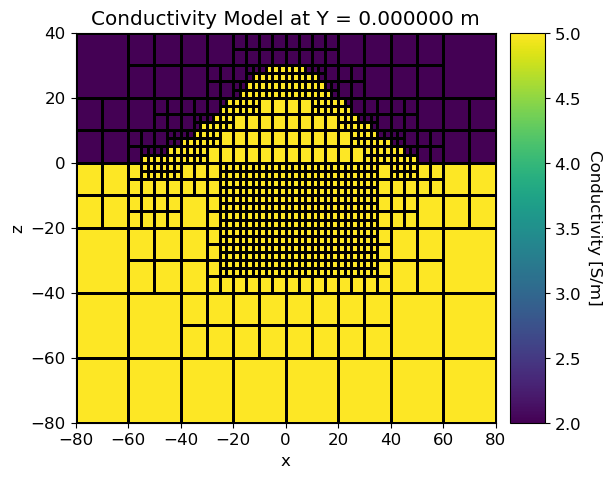

In [158]:
def make_example_mesh():
    # Base mesh parameters
    dh = 2.5  # base cell size
    nbc = 2048  # total width of mesh in terms of number of base mesh cells
    h = dh * np.ones(nbc)

    mesh = TreeMesh([h, h, h], x0="CCC")

    # Refine to largest possible cell size
    mesh.refine(3, finalize=False)

    return mesh


dom_width=50
xx, yy = np.meshgrid(np.linspace(-dom_width, dom_width, 101), np.linspace(-dom_width, dom_width, 101))
zz = np.zeros(np.shape(xx))
Q=1e-3
zz = np.exp(-Q*xx**2 - Q*yy**2)*30
topo = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]

depth_tunnel=10

def refine_topography(mesh):
    # Define topography and refine
#     [xx, yy] = np.meshgrid(mesh.nodes_x, mesh.nodes_y)
#     zz = -3. * np.exp((xx**2 + yy**2) / 50**2) + 45.0
#     topo = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]
  
    
    mesh = refine_tree_xyz(
        mesh, topo, octree_levels=[3, 2], method="surface", finalize=False
    )


    return mesh

def refine_box(mesh):
    # Refine for sphere
#     xp, yp, zp = np.meshgrid([-55.0, 50.0], [-50.0, 50.0], [-40.0, 20.0])
#     xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
    
    xp, yp, zp = np.meshgrid([-25.0, 35.0],[-25.0, 25.0], [-depth_tunnel-20, -5.0])
    xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)] 

    mesh = refine_tree_xyz(mesh, xyz, octree_levels=[2], method="box", finalize=False)

    return mesh

def create_mesh():
    mesh = make_example_mesh()
    mesh = refine_topography(mesh)
    mesh = refine_box(mesh)
    mesh.finalize()
    
    sig_air = 1e-8

    # Find cells that are active in the forward modeling (cells below surface)
    ind_active = surface2ind_topo(mesh, topo)

    # Define mapping from model to active cells
    model_map = maps.InjectActiveCells(mesh, ind_active, sig_air)
    plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
    
    return mesh,ind_active,model_map,plotting_map

mesh,ind_active,model_map,plotting_map=create_mesh()
background_value = 100.0
dyke_value = 40.0
block_value = 70.0

# Define surface topography as an (N, 3) np.array. You could also load a file
# containing the xyz points
# [xx, yy] = np.meshgrid(mesh.nodes_x, mesh.nodes_y)
# zz = -3. * np.exp((xx**2 + yy**2) / 50**2) + 45.0
# topo = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]

# Find cells below topography and define mapping
air_value = 0.0
ind_active = active_from_xyz(mesh, topo)
model_map = maps.InjectActiveCells(mesh, ind_active, air_value)

# Define the model on subsurface cells
model = background_value * np.ones(ind_active.sum())





def plotmod(model,yref):
    # Plot Resistivity Model
    mpl.rcParams.update({"font.size": 12})
    fig = plt.figure(figsize=(7, 6))
    

    indy = int(np.argmin(abs(mesh.vectorCCy-yref)))
    ax1 = fig.add_axes([0.13, 0.1, 0.6, 0.65])
    mesh.plot_slice(
        model_map * model,
        normal="Y",
        ax=ax1,
        ind=indy,
        grid=True,
        clim=(2, 5),
    )
    ax1.set_title("Conductivity Model at Y = %f m" %yref)

    lim_len=80
    xlim = [-lim_len, lim_len]
    ylim = [-lim_len, lim_len/2]
    zlim = [-lim_len, lim_len]
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)

    ax2 = fig.add_axes([0.75, 0.1, 0.05, 0.65])
    norm = mpl.colors.Normalize(
        vmin=2, vmax=5
    )
    cbar = mpl.colorbar.ColorbarBase(
        ax2,norm=norm, orientation="vertical", format="$%.1f$"
    )
    cbar.set_label("Conductivity [S/m]", rotation=270, labelpad=15, size=12)

plotmod(model,yref=0)   




## Combo Maps

Here we demonstrate how combo maps can be used to create a single mapping
from the model to the mesh. In this case, our model consists of
log-conductivity values but we want to plot the resistivity. To accomplish
this we must take the exponent of our model values, then take the reciprocal,
then map from below surface cell to the mesh.




In [ ]:
mesh = make_example_mesh()
mesh = refine_topography(mesh)
mesh = refine_box(mesh)
mesh.finalize()

background_value = np.log(1.0 / 100.0)
dyke_value = np.log(1.0 / 40.0)
block_value = np.log(1.0 / 70.0)

# Define surface topography
[xx, yy] = np.meshgrid(mesh.nodes_x, mesh.nodes_y)
zz = -3 * np.exp((xx**2 + yy**2) / 60**2) + 45.0
topo = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]

# Find cells below topography
air_value = 0.0
ind_active = active_from_xyz(mesh, topo)
active_map = maps.InjectActiveCells(mesh, ind_active, air_value)

# Define the model on subsurface cells
model = background_value * np.ones(ind_active.sum())
ind_dyke = (mesh.gridCC[ind_active, 0] > 20.0) & (mesh.gridCC[ind_active, 0] < 40.0)
model[ind_dyke] = dyke_value
ind_block = (
    (mesh.gridCC[ind_active, 0] > -40.0)
    & (mesh.gridCC[ind_active, 0] < -10.0)
    & (mesh.gridCC[ind_active, 1] > -30.0)
    & (mesh.gridCC[ind_active, 1] < 30.0)
    & (mesh.gridCC[ind_active, 2] > -40.0)
    & (mesh.gridCC[ind_active, 2] < 0.0)
)
model[ind_block] = block_value

# Define a single mapping from model to mesh
exponential_map = maps.ExpMap()
reciprocal_map = maps.ReciprocalMap()
model_map = active_map * reciprocal_map * exponential_map

# Plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ind_slice = int(mesh.h[1].size / 2)
mesh.plot_slice(model_map * model, normal="Y", ax=ax, ind=ind_slice, grid=True)
ax.set_title(
    "Model slice at y = {} m".format(mesh.x0[1] + np.sum(mesh.h[1][0:ind_slice]))
)
plt.show()

## Models with arbitrary shapes

Here we show how model building utilities are used to make more complicated
structural models. The process of adding a new unit is twofold: 1) we must
find the indicies for mesh cells that lie within the new unit, 2) we
replace the prexisting physical property value for those cells.




In [ ]:
mesh = make_example_mesh()
mesh = refine_topography(mesh)
mesh = refine_box(mesh)
mesh.finalize()

background_value = 100.0
dyke_value = 40.0
sphere_value = 70.0

# Define surface topography
[xx, yy] = np.meshgrid(mesh.nodes_x, mesh.nodes_y)
zz = -3 * np.exp((xx**2 + yy**2) / 60**2) + 45.0
topo = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]

# Set active cells and define unit values
air_value = 0.0
ind_active = active_from_xyz(mesh, topo)
model_map = maps.InjectActiveCells(mesh, ind_active, air_value)

# Define model for cells under the surface topography
model = background_value * np.ones(ind_active.sum())

# Add a sphere
ind_sphere = model_builder.get_indices_sphere(
    np.r_[-25.0, 0.0, -15.0], 20.0, mesh.gridCC
)
ind_sphere = ind_sphere[ind_active]  # So same size and order as model
model[ind_sphere] = sphere_value

# Add dyke defined by a set of points
xp = np.kron(np.ones((2)), [-10.0, 10.0, 55.0, 35.0])
yp = np.kron([-1000.0, 1000.0], np.ones((4)))
zp = np.kron(np.ones((2)), [-120.0, -120.0, 45.0, 45.0])
xyz_pts = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
ind_polygon = model_builder.get_indices_polygon(mesh, xyz_pts)
ind_polygon = ind_polygon[ind_active]  # So same size and order as model
model[ind_polygon] = dyke_value

# Plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ind_slice = int(mesh.h[1].size / 2)
mesh.plot_slice(model_map * model, normal="Y", ax=ax, ind=ind_slice, grid=True)
ax.set_title(
    "Model slice at y = {} m".format(mesh.x0[1] + np.sum(mesh.h[1][0:ind_slice]))
)
plt.show()

## Parameterized block model

Instead of defining a model value for each sub-surface cell, we can define
the model in terms of a small number of parameters. Here we parameterize the
model as a block in a half-space. We then create a mapping which projects
this model onto the mesh.




In [ ]:
mesh = make_example_mesh()
mesh = refine_topography(mesh)
mesh = refine_box(mesh)
mesh.finalize()

background_value = 100.0  # background value
block_value = 40.0  # block value
xc, yc, zc = -20.0, 0.0, -20.0  # center of block
dx, dy, dz = 25.0, 40.0, 30.0  # dimensions in x,y,z

# Define surface topography
[xx, yy] = np.meshgrid(mesh.nodes_x, mesh.nodes_y)
zz = -3 * np.exp((xx**2 + yy**2) / 60**2) + 45.0
topo = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]

# Set active cells and define unit values
air_value = 0.0
ind_active = active_from_xyz(mesh, topo)
active_map = maps.InjectActiveCells(mesh, ind_active, air_value)

# Define the model on subsurface cells
model = np.r_[background_value, block_value, xc, dx, yc, dy, zc, dz]
parametric_map = maps.ParametricBlock(
    mesh, active_cells=ind_active, epsilon=1e-10, p=5.0
)

# Define a single mapping from model to mesh
model_map = active_map * parametric_map

# Plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ind_slice = int(mesh.h[1].size / 2)
mesh.plot_slice(model_map * model, normal="Y", ax=ax, ind=ind_slice, grid=True)
ax.set_title(
    "Model slice at y = {} m".format(mesh.x0[1] + np.sum(mesh.h[1][0:ind_slice]))
)
plt.show()

## Using Wire Maps

Wire maps are needed when the model is comprised of two or more parameter
types (e.g. conductivity and magnetic permeability). Because the model
vector contains all values for all parameter types, we need to use "wires"
to extract the values for a particular parameter type.

Here we will define a model consisting of log-conductivity values and
magnetic permeability values. We wish to plot the conductivity and
permeability on the mesh. Wires are used to keep track of the mapping
between the model vector and a particular physical property type.




In [ ]:
mesh = make_example_mesh()
mesh = refine_topography(mesh)
mesh = refine_box(mesh)
mesh.finalize()

background_sigma_value = np.log(100.0)
sphere_sigma_value = np.log(70.0)
dyke_sigma_value = np.log(40.0)
background_mu_value = 1.0
sphere_mu_value = 1.25

# Define surface topography
[xx, yy] = np.meshgrid(mesh.nodes_x, mesh.nodes_y)
zz = -3 * np.exp((xx**2 + yy**2) / 60**2) + 45.0
topo = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]

# Set active cells
air_value = 0.0
ind_active = active_from_xyz(mesh, topo)
active_map = maps.InjectActiveCells(mesh, ind_active, air_value)

# Define model for cells under the surface topography
N = int(ind_active.sum())
model = np.kron(np.ones((N, 1)), np.c_[background_sigma_value, background_mu_value])

# Add a conductive and permeable sphere
ind_sphere = model_builder.get_indices_sphere(
    np.r_[-20.0, 0.0, -15.0], 20.0, mesh.gridCC
)
ind_sphere = ind_sphere[ind_active]  # So same size and order as model
model[ind_sphere, :] = np.c_[sphere_sigma_value, sphere_mu_value]

# Add a conductive and non-permeable dyke
xp = np.kron(np.ones((2)), [-10.0, 10.0, 55.0, 35.0])
yp = np.kron([-1000.0, 1000.0], np.ones((4)))
zp = np.kron(np.ones((2)), [-120.0, -120.0, 45.0, 45.0])
xyz_pts = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
ind_polygon = model_builder.get_indices_polygon(mesh, xyz_pts)
ind_polygon = ind_polygon[ind_active]  # So same size and order as model
model[ind_polygon, 0] = dyke_sigma_value

# Create model vector and wires
model = mkvc(model)
wire_map = maps.Wires(("log_sigma", N), ("mu", N))

# Use combo maps to map from model to mesh
sigma_map = active_map * maps.ExpMap() * wire_map.log_sigma
mu_map = active_map * wire_map.mu

# Plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ind_slice = int(mesh.h[1].size / 2)
mesh.plot_slice(sigma_map * model, normal="Y", ax=ax, ind=ind_slice, grid=True)
ax.set_title(
    "Model slice at y = {} m".format(mesh.x0[1] + np.sum(mesh.h[1][0:ind_slice]))
)
plt.show()